# Team Members:
> - Seif Yasser
> - Mohammed Yasser
> - Omar Ahmed

In [730]:
import os
import math
import torch
import random
import pandas as pd
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from torchviz import make_dot
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from utils.yaml import Config


In [731]:
cfg=Config.load()

In [732]:
# BATCH_SIZE = 32
# LEARNING_RATE = 0.001
EPOCHS = 10
NUM_CLASSES = cfg['NUM_CLASSES']
BETAS=cfg['BETAS']

In [733]:
# Model_trainingmethod_optimizer_lr_scheduler_batch_size_lossfn_weightdecay
run_names = cfg['run_names']
run_names

['Custom_Naive_adam_0.001_None_32_crossentropy_wd0',
 'Custom_Naive_adam_0.001_None_32_KLDivLoss_wd0',
 'Custom_Naive_adam_0.001_None_32_svm_wd0',
 'Custom_Naive_sgd_0.1_step_32_crossentropy_wd0',
 'Custom_Naive_sgd_0.1_cosine_32_crossentropy_wd0',
 'Custom_Naive_rmsprop_0.1_None_32_crossentropy_wd0',
 'Custom_Naive_rmsprop_0.01_None_32_crossentropy_wd0',
 'Custom_Naive_rmsprop_0.1_None_16_crossentropy_wd0',
 'Custom_Naive_rmsprop_0.01_None_16_crossentropy_wd0',
 'Custom_Naive_adagrad_0.01_None_32_crossentropy_wd1e-6',
 'Custom_Naive_adagrad_0.01_None_32_crossentropy_wd1e-7',
 'ResNet_Transfer_adam_0.01_None_32_crossentropy_wd0',
 'ResNet_Naive_adam_0.01_None_32_crossentropy_wd0',
 'AlexNet_Transfer_adam_0.01_None_32_crossentropy_wd0',
 'AlexNet_Naive_adam_0.01_None_32_crossentropy_wd0',
 'GoogLeNet_Transfer_adam_0.01_None_32_crossentropy_wd0',
 'GoogLeNet_Naive_adam_0.01_None_32_crossentropy_wd0',
 'VGG16_Transfer_adam_0.01_None_32_crossentropy_wd0',
 'VGG16_Naive_adam_0.01_None_32_cr

In [734]:
# dataset_path = '../data/sidharkal-sports-image-classification/dataset'
dataset_path = cfg['dataset_path']

In [735]:
class SportsDataset(Dataset):
    def __init__(self, csv_file, file_path, split='train', transform=None):

        self.data_info = pd.read_csv(csv_file)
        # self.root_dir = os.path.join(file_path, split)
        self.root_dir = os.path.join(file_path, 'train')
        self.transform = transform
        self.split = split
        # Build string → index mapping from all labels in this split
        # if split == 'train':
        label_column = self.data_info.iloc[:, 1]  # assuming 2nd column is the label
        classes = sorted(label_column.unique())
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        print(f"Classes: {self.class_to_idx}")

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        # 1) Load image
        img_name = os.path.join(self.root_dir, self.data_info.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        # 2) Apply transforms
        if self.transform:
            image = self.transform(image)

        # if self.split=='train':
        # 3) String label → integer index
        label_str = self.data_info.iloc[idx, 1]
        label_idx = self.class_to_idx[label_str]

            # 4) Return image tensor, label tensor
        return image, torch.tensor(label_idx, dtype=torch.int8)
        # else:
        #     # 3) Return image tensor, label tensor
        #     return image


In [736]:
train_csv_path= os.path.join(dataset_path, 'train.csv')
test_csv_path= os.path.join(dataset_path, 'test.csv')

In [737]:
data_csv = pd.read_csv(train_csv_path)

In [738]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Let's create train and test splits from the data_csv DataFrame

# # Split the data into training (80%) and testing (20%) sets
# train_data, test_data = train_test_split(data_csv, test_size=0.2, random_state=42, stratify=data_csv['label'])

# # Reset indices
# train_data = train_data.reset_index(drop=True)
# test_data = test_data.reset_index(drop=True)

# # Display the shapes of the resulting datasets
# print(f"Original data shape: {data_csv.shape}")
# print(f"Train data shape: {train_data.shape}")
# print(f"Test data shape: {test_data.shape}")

# # Verify label distribution in both sets
# print("\nLabel distribution in original data:")
# print(data_csv['label'].value_counts())
# print("\nLabel distribution in train data:")
# print(train_data['label'].value_counts())
# print("\nLabel distribution in test data:")
# print(test_data['label'].value_counts())

# # Save the CSV files
# train_data_path = '../data/sidharkal-sports-image-classification/dataset/train_data.csv'
# test_data_path = '../data/sidharkal-sports-image-classification/dataset/test_data.csv'

# train_data.to_csv(train_csv_path, index=False)
# test_data.to_csv(test_csv_path, index=False)

# print(f"\nTrain data saved to: {train_data_path}")
# print(f"Test data saved to: {test_data_path}")

In [739]:
data_csv['label'].nunique() # 7 classes

7

In [740]:
label_counts = data_csv['label'].value_counts()


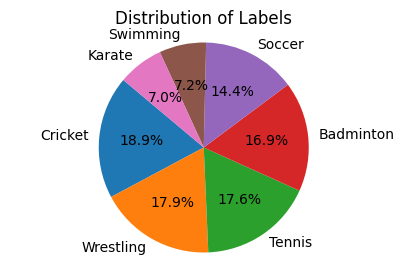

In [741]:
plt.figure(figsize=(5, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels')
plt.axis('equal') 
plt.show()

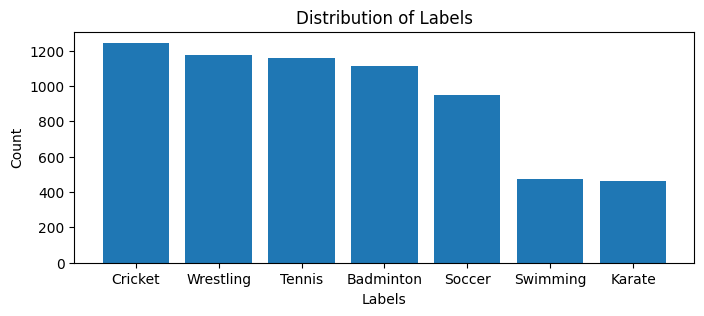

In [742]:
plt.figure(figsize=(8, 3))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

In [743]:
transforms = transforms.Compose([

    transforms.RandomResizedCrop(
        224,
        scale=(0.8, 1.0),
        ratio=(0.75, 1.3333)
    ),

    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),

    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    # transforms.Resize((224, 224)),  # remove if RandomResizedCrop already gives 224×224
    transforms.ToTensor(),

    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

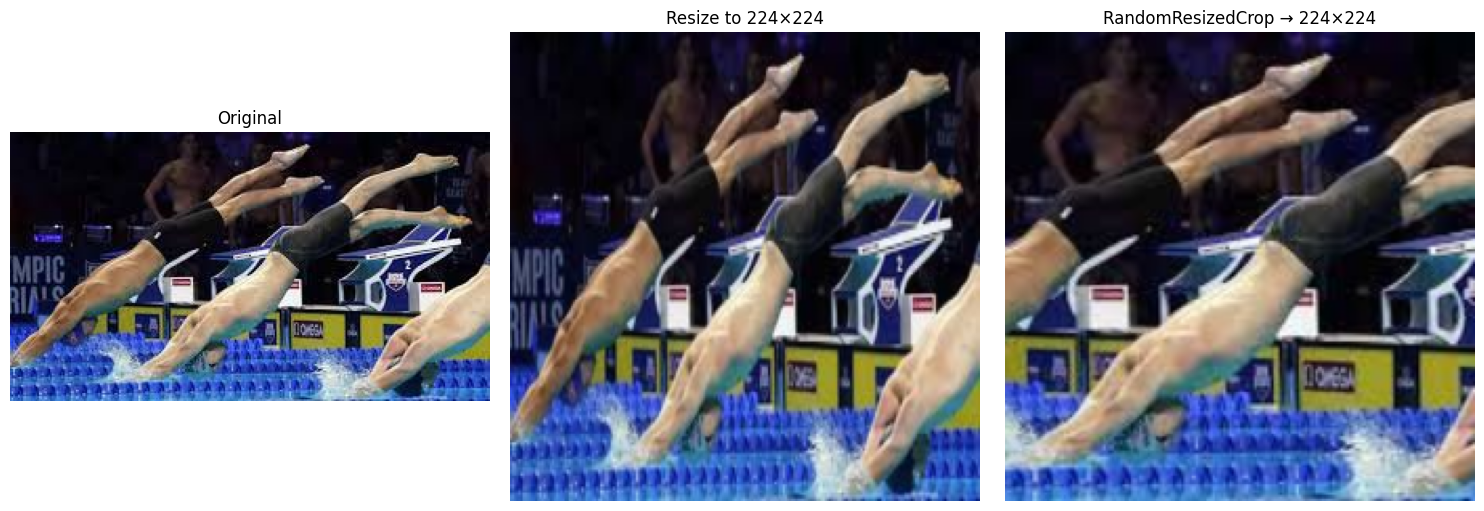

In [744]:
# === User Parameters ===
# Replace this with the path to your real image file
IMAGE_PATH = "../data\\sidharkal-sports-image-classification\\dataset\\train\\0a1a257824.jpg"

# === Load the image ===
image = Image.open(IMAGE_PATH).convert("RGB")

# === Define transforms ===
def resize_image(img, size=(224, 224)):
    """Deterministic resize to `size`."""
    return img.resize(size, Image.BILINEAR)

def random_resized_crop(img, size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), seed=0):
    """Randomly crop a region then resize it to `size`."""
    random.seed(seed)
    width, height = img.size
    area = width * height

    # pick target area and aspect ratio
    target_area = random.uniform(*scale) * area
    aspect_ratio = random.uniform(*ratio)

    w = int(round(math.sqrt(target_area * aspect_ratio)))
    h = int(round(math.sqrt(target_area / aspect_ratio)))

    # fallback to center square if too large
    if w > width or h > height:
        min_dim = min(width, height)
        w = h = min_dim

    # random top-left corner
    x = random.randint(0, width - w)
    y = random.randint(0, height - h)

    crop = img.crop((x, y, x + w, y + h))
    return crop.resize(size, Image.BILINEAR)

# Apply transforms
resized = resize_image(image)
cropped = random_resized_crop(image, seed=42)

# === Display results ===
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(resized)
axes[1].set_title("Resize to 224×224")
axes[1].axis("off")

axes[2].imshow(cropped)
axes[2].set_title("RandomResizedCrop → 224×224")
axes[2].axis("off")

plt.tight_layout()
plt.show()


In [745]:
# train_dataset = SportsDataset(csv_file=train_csv_path, file_path=dataset_path, split='train', transform=transforms)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [746]:
# test_dataset = SportsDataset(csv_file=test_csv_path, file_path=dataset_path, split='test', transform=transforms)

# val_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [747]:
def show_tensor_images(image_tensor):
    # Detach tensor and ensure it's on CPU, then take the first image if batch exists
    img = image_tensor.detach().cpu()
    
    # If the image has a single channel, treat it as grayscale
    if img.dim() == 2 or img.shape[0] == 1:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        # If image is normalized (using the usual ImageNet means and stds), de-normalize it
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = img.clamp(0, 1)
        # Convert tensor (C, H, W) → (H, W, C) for RGB plotting
        plt.imshow(img.permute(1, 2, 0))
    
    plt.axis("off")
    plt.show()

In [748]:
# show_tensor_images(train_loader.dataset[5][0])

In [749]:
class Block(nn.Module):
    def __init__(self,in_channels,out_channels,act='relu',drop=False,norm=True):
        super().__init__()
        self.drop=drop
        self.norm=norm
        self.dropout=nn.Dropout(0.5)
        if self.norm==True:
            self.block=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,4,2,1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
            )
        else:
            self.block=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,4,2,1),
                nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
            )
    def forward(self,x):
        x=self.block(x)
        return self.dropout(x) if self.drop else x

In [750]:
def calc_ouput_size(input_size, kernel_size, stride, padding):
    return (input_size - kernel_size + 2 * padding) // stride + 1

In [751]:
calc_ouput_size(224, 4, 2, 1)

112

In [752]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=7, input_channels=3, input_size=(224, 224),dropout=0.5,hidden_dim=64):
        super(CustomCNN, self).__init__()
        self.conv1 = Block(input_channels, hidden_dim, act='relu', drop=False, norm=False) # 3x224x224 -> 64x112x112
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 64x112x112 -> 64x56x56
        self.conv2 = Block(hidden_dim, hidden_dim, act='relu', drop=False, norm=False) # 64x56x56 -> 64x28x28
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64x28x28 -> 64x14x14
        self.conv3 = Block(hidden_dim, hidden_dim*2, act='relu', drop=False, norm=False) # 64x14x14 -> 128x7x17
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128x7x7 -> 128x3x3
        self.conv4 = Block(hidden_dim*2, hidden_dim*2, act='relu', drop=False, norm=False) 
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2) # 128x3x3 -> 128x1x1
        self.fc1 = nn.Linear(128, 128)  #  128 -> 128
        self.relu=nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, num_classes) # 128 -> num_classes
        self.sigmoid = nn.Sigmoid()
        self.fc3 = nn.Linear(128*3*3, 128) # 128 -> num_classes

    def forward(self, x):
        # x = self.conv1(x)
        # x = self.maxpool1(x)
        # x = self.conv2(x)
        # x = self.maxpool2(x)
        # x = self.conv3(x)
        # x = self.maxpool3(x)
        # x = self.conv4(x)
        # x = x.view(x.size(0), -1)
        # x = self.fc1(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        # x = self.fc2(x)
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x=self.fc3(x.view(x.size(0), -1))
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [753]:
def xavier_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
            

def kaiming_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

def msra_init(m):
    # MSRA is another name for kaiming initialization
    # but often focuses on fan_in mode specifically
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

def custom_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm3d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [754]:
def init_weights(model, init_type='xavier'):
    if init_type == 'xavier':
        model.apply(xavier_init)
    elif init_type == 'kaiming':
        model.apply(kaiming_init)
    elif init_type == 'msra':
        model.apply(msra_init)
    elif init_type == 'custom':
        model.apply(custom_init)
    else:
        raise ValueError(f"Unknown initialization type: {init_type}")

In [755]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [756]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
    
    def __call__(self, val_loss, model, path='checkpoint.pt'):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model, path):
        """Save model when validation loss decreases."""
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss


In [757]:
def load_pretrained_model(model_class, number_freeze_layers=0, device='cuda'):
    """
    Load a pretrained model, freeze the first `number_freeze_layers` child modules,
    replace its head with a 7-class classifier, and print parameter statistics.
    """
    # 1) Load the pretrained model
    model = model_class(pretrained=True)

    # 2) Freeze the first `number_freeze_layers` child modules
    if number_freeze_layers > 0:
        children = list(model.children())
        for layer in children[:number_freeze_layers]:
            for param in layer.parameters():
                param.requires_grad = False

    # 3) Replace the final fully-connected layer for 7 classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 7)

    # 4) Move model to the target device
    model = model.to(device)

    # 5) Compute parameter counts
    total_params     = sum(p.numel() for p in model.parameters())
    frozen_params    = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    trainable_params = total_params - frozen_params

    # 6) Print out the statistics
    print("Model statistics:")
    print(f"  Total parameters:     {total_params:,}")
    print(f"  Frozen parameters:   {frozen_params:,} ({frozen_params/total_params:.2%})")
    print(f"  Trainable parameters:{trainable_params:,} ({trainable_params/total_params:.2%})")

    return model

In [758]:
def initialize_model(model_class=CustomCNN,training_method='Naive', num_classes=NUM_CLASSES, input_channels=3, input_size=(224, 224), dropout=0.5, hidden_dim=64,pretrained_weights=None, weight_init_method='custom',number_freeze_layers=0, device='cuda'):
    # classifier=CustomCNN(num_classes=NUM_CLASSES, input_channels=3, input_size=(224, 224),dropout=0.5,hidden_dim=64)
    if isinstance(model_class, CustomCNN):

        model = model_class(num_classes=num_classes, input_channels=input_channels, input_size=input_size, dropout=dropout, hidden_dim=hidden_dim)
    # elif isinstance(model_class, str):
        # if model_class == 'AlexNet':
        init_weights(model, init_type=weight_init_method)
    else:
        if training_method == 'Naive':
            model = model(pretrained=False)
        elif training_method == 'Transfer':
            # model = model(pretrained=True)
            model=load_pretrained_model(model_class, number_freeze_layers=number_freeze_layers, device=device)
            # model.load_state_dict(torch.load(pretrained_weights))

    model.to(device)
    return model

In [759]:
def initialize_optimizer(model,optimizer, learning_rate=0.001, betas=(0.9, 0.999), weight_decay=0.0001):
    if optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas)
    elif optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer=="rmsprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99, eps=1e-08, weight_decay=weight_decay, centered=False)
    elif optimizer == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, lr_decay=0, weight_decay=weight_decay, initial_accumulator_value=0, eps=1e-10)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer}")
    return optimizer

In [760]:
def initialize_loss_function(loss_fn='crossentropy'):
    if loss_fn == 'crossentropy':
        criterion = nn.CrossEntropyLoss()
    elif loss_fn == 'KLDivLoss':
        criterion = nn.KLDivLoss(reduction='batchmean')
    elif loss_fn == 'svm':
        criterion=nn.MultiMarginLoss(margin=1.0)
    else:
        raise ValueError(f"Unknown loss function: {loss_fn}")
    criterion.to(device)
    return criterion

In [761]:
def initialize_lr_scheduler(optimizer, scheduler_type='step', step_size=10, gamma=0.1):
    if scheduler_type == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    elif scheduler_type == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=0)
    elif scheduler_type=='linear':
        scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=EPOCHS)
    else:
        raise ValueError(f"Unknown scheduler type: {scheduler_type}")
    return scheduler

In [762]:
def initialize_tensorboard_writer(log_directory, run_name):
    # Create a directory for the logs if it doesn't exist
    os.makedirs(log_directory, exist_ok=True)
    
    # Initialize the SummaryWriter
    writer = SummaryWriter(log_dir=os.path.join(log_directory, run_name))
    return writer

In [763]:
def initialize_early_stopping(patience=5, delta=0):
    early_stopping = EarlyStopping(patience=patience, delta=delta)
    return early_stopping

In [764]:
def initialize_data_loaders(train_csv_path, test_csv_path, dataset_path, transforms):
    train_dataset = SportsDataset(csv_file=train_csv_path, file_path=dataset_path, split='train', transform=transforms)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataset = SportsDataset(csv_file=test_csv_path, file_path=dataset_path, split='test', transform=transforms)

    val_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    return train_loader, val_loader

In [765]:
def draw_save_graph(model, name='custom_arch_graph'):
    # Create the directory if it doesn't exist
    graph_dir = '../models/graphs'
    os.makedirs(graph_dir, exist_ok=True)
    
    # Create full path for the graph
    path = os.path.join(graph_dir, name)
    
    # Create a graph of the model
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    dot = make_dot(model(sample_input), params=dict(list(model.named_parameters())))
    
    # Save the graph as a PNG file
    dot.format = 'png'
    dot.render(filename=path, cleanup=True)
    print(f"Graph saved to {path}.png")

In [766]:
def initialize_all(run_name='custom_arch_graph',model_class=CustomCNN,training_method='Naive', num_classes=NUM_CLASSES, input_channels=3, input_size=(224, 224), dropout=0.5, hidden_dim=64,betas=BETAS, optimizer='adam', learning_rate=0.001, weight_decay=0.0001,loss_fn='crossentropy',scheduler_type=None,log_directory='../logs',number_freeze_layers=0, device='cuda'):
    train_loader, val_loader=initialize_data_loaders(train_csv_path, test_csv_path, dataset_path, transforms)
    criterion=initialize_loss_function(loss_fn=loss_fn)
    model=initialize_model(model_class=model_class,training_method=training_method, num_classes=num_classes, input_channels=input_channels, input_size=input_size, dropout=dropout, hidden_dim=hidden_dim, number_freeze_layers=number_freeze_layers, device=device)
    draw_save_graph(model,name=run_name)
    optimizer=initialize_optimizer(model,optimizer,learning_rate=learning_rate,betas=betas,weight_decay=weight_decay)
    if scheduler_type:
        scheduler=initialize_lr_scheduler(optimizer, scheduler_type=scheduler_type, step_size=25, gamma=0.1)
    else:
        scheduler=None
    writer=initialize_tensorboard_writer(log_directory, run_name)
    early_stopping=initialize_early_stopping()
    
    return model, optimizer, criterion, scheduler, writer, early_stopping, train_loader, val_loader
    # initialize_checkpoint_manager()
    # initialize_logger()

In [767]:
def save_model(run_name,model,epoch,optimizer,train_loss,batch_size=32,lr=0.01,num_classes=7):
    batch_size=int(run_name.split('_')[5])
    lr=float(run_name.split('_')[3])
    checkpoint_path = f'../models/checkpoints/model{run_name}_epoch_{epoch+1}.pth'
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'hyperparameters': {
            'BATCH_SIZE': batch_size,
            'LEARNING_RATE': lr,
            # 'BETAS': betas,
            'NUM_CLASSES': num_classes
        },
        'loss': train_loss,
    }, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")

In [768]:
def plot_loss_acc(run_name,epoch,losses, accuracies):
    print(losses)
    print(epoch+1)
    # Plot and save the training curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch+2), losses)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch+2), accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.savefig(f'../logs/plots/training_curves_{run_name}_{epoch+1}.png')
    plt.show()

In [769]:
def training_loop(
    run_name,
    num_epochs,
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    writer,
    scheduler=None
):
    os.makedirs('../logs/plots', exist_ok=True)
    train_losses, train_accs = [], []
    val_losses, val_accs     = [], []

    for epoch in range(num_epochs):
        # ----- Training -----
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        train_bar = tqdm(
            train_loader,
            desc=f"[Epoch {epoch+1}/{num_epochs}] Train",
            leave=False
        )
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device).long()
            optimizer.zero_grad()

            outputs = model(images)
            if isinstance(criterion, nn.KLDivLoss):
                log_probs    = F.log_softmax(outputs, dim=1)
                target_probs = F.one_hot(labels, num_classes=outputs.size(1)).float()
                loss = criterion(log_probs, target_probs)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct  += (preds == labels).sum().item()
            total    += labels.size(0)

            batch_loss = loss.item()
            batch_acc  = correct / total
            train_bar.set_postfix({
                'loss': f"{batch_loss:.4f}",
                'acc':  f"{batch_acc:.2%}"
            })
            writer.add_scalar(
                'Loss/Train_Batch',
                batch_loss,
                epoch * len(train_loader) + train_bar.n
            )

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc  = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        writer.add_scalar('Loss/Train', epoch_train_loss, epoch)
        writer.add_scalar('Accuracy/Train', epoch_train_acc, epoch)

        # ----- Validation -----
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        val_bar = tqdm(
            val_loader,
            desc=f"[Epoch {epoch+1}/{num_epochs}] Val  ",
            leave=False
        )
        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device).long()

                outputs = model(images)
                if isinstance(criterion, nn.KLDivLoss):
                    log_probs    = F.log_softmax(outputs, dim=1)
                    target_probs = F.one_hot(labels, num_classes=outputs.size(1)).float()
                    loss_val = criterion(log_probs, target_probs)
                else:
                    loss_val = criterion(outputs, labels)

                running_loss += loss_val.item() * images.size(0)
                _, preds_val = outputs.max(1)
                correct     += (preds_val == labels).sum().item()
                total       += labels.size(0)

                batch_loss = loss_val.item()
                batch_acc  = correct / total
                val_bar.set_postfix({
                    'loss': f"{batch_loss:.4f}",
                    'acc':  f"{batch_acc:.2%}"
                })
                writer.add_scalar(
                    'Loss/Val_Batch',
                    batch_loss,
                    epoch * len(val_loader) + val_bar.n
                )

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc  = correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        writer.add_scalar('Loss/Val', epoch_val_loss, epoch)
        writer.add_scalar('Accuracy/Val', epoch_val_acc, epoch)

        # ----- LR Scheduler -----
        if scheduler is not None:
            scheduler.step()
            writer.add_scalar('Learning_Rate', scheduler.get_last_lr()[0], epoch)

        # ----- Epoch Summary -----
        print(
            f"Epoch [{epoch+1}/{num_epochs}]  "
            f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}  |  "
            f"Val Loss:   {epoch_val_loss:.4f}, Val Acc:   {epoch_val_acc:.4f}"
        )

        # ----- Checkpoint & Plot -----
        if (epoch + 1) % 7 == 0:
            save_model(run_name, model, epoch, optimizer, epoch_train_loss, num_classes=7)
            plot_loss_acc(run_name, epoch, train_losses, train_accs)

    # return train_losses, train_accs, val_losses, val_accs


In [770]:
from utils.optuna import run_optuna_study,objective

In [771]:
# train_loader, val_loader=initialize_data_loaders(train_csv_path, test_csv_path, dataset_path, transforms)

In [772]:
def objective(trial):
    # Define the hyperparameters to search
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical(
        'optimizer', ['Adam', 'SGD', 'RMSprop'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)

    # Setup model
    model = CustomCNN()  # your model here
    model = model.to(device)

    # Dataloader
    train_dataset = SportsDataset(
        csv_file=train_csv_path, file_path=dataset_path, split='train', transform=transforms)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(torch.optim, optimizer_name)(
        model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop (1-3 epochs is enough for Optuna)
    for epoch in range(3):
        model.train()
        running_loss = 0.0

        # Training progress bar
        train_pbar = tqdm(
            train_loader, desc=f"Trial {trial.number}, Epoch {epoch+1}/3 (Train)")
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(device), targets.to(device).long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_pbar.set_postfix({'loss': running_loss/(train_pbar.n+1)})

    # Validation accuracy
    model.eval()
    correct = 0
    total = 0

    # Validation progress bar
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Trial {trial.number}, Validation")
        for inputs, targets in val_pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

            # Update progress bar with current accuracy
            val_pbar.set_postfix({'acc': correct/total})

    accuracy = correct / total
    trial.set_user_attr('final_accuracy', accuracy)
    return accuracy


In [773]:
device

device(type='cuda')

In [774]:
# run_optuna_study(objective=objective, n_trials=10)

In [775]:
# best_params={'lr': 0.00046038237663399744, 'optimizer': 'Adam', 'batch_size': 32, 'weight_decay': 0.00031783771069456555}

In [776]:
def log_hyperparameters(writer, hyperparameters_dict):
    writer.add_hparams(
        hparam_dict= hyperparameters_dict,
        metric_dict={
        }
    )

In [777]:
log_directory = '../logs'

train_model -> initialize_all -> log_hyperparameters -> training_loop -> save_model

In [778]:
def train_model(class_model,training_method,model_name,optimizer, criterion, num_epochs=100,batch_size=32,learning_rate=0.01,betas=(0.9, 0.999),loss_fn='crossentropy', device='cuda',num_classes=7,weight_decay=0.0001,scheduler_type='step',number_frozen_layers=0):

    if class_model == 'CustomCNN':
        class_model = CustomCNN
    elif class_model == 'ResNet':
        from torchvision.models import resnet50
        class_model = resnet50

    elif class_model == 'AlexNet':
        from torchvision.models import alexnet
        class_model = alexnet
    elif class_model == 'VGG16':
        from torchvision.models import vgg16
        class_model = vgg16
    elif class_model == 'VGG19':
        from torchvision.models import vgg19
        class_model = vgg19
    elif class_model == 'GoogLeNet':
        from torchvision.models import googlenet
        class_model = googlenet

    model, optimizer, criterion, scheduler, writer, early_stopping, train_loader, val_loader = initialize_all(
        run_name=model_name,
        training_method=training_method,
        model_class=class_model,
        num_classes=num_classes,
        input_channels=3,
        input_size=(224, 224),
        dropout=0.5,
        hidden_dim=64,
        betas=betas,
        optimizer=optimizer,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        loss_fn=loss_fn,
        scheduler_type=scheduler_type,
        number_freeze_layers=number_frozen_layers
    )
    hyperparameters_dict={
        "BATCH_SIZE":     batch_size,
            "LEARNING_RATE":  learning_rate,
            "EPOCHS":         num_epochs,
            "BETAS":          str(betas),
            "NUM_CLASSES":    num_classes,
    }
    log_hyperparameters(writer, hyperparameters_dict)
    
    training_loop(run_name=model_name,num_epochs=num_epochs, model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device,writer=writer, scheduler=scheduler,val_loader=val_loader)
    # save_model(model, path=f'../models/pretrained/{model_name}.pth', optimizer=optimizer)
    
    writer.close()

In [779]:
run_name=run_names[11]

In [780]:
def parse_run_name(run_name):
    architecture=run_name.split('_')[0]
    training_method=run_name.split('_')[1]
    optimizer=run_name.split('_')[2]
    learning_rate=float(run_name.split('_')[3])
    learning_scheduler=run_name.split('_')[4]=None if 'None' in run_name.split('_')[4] else run_name.split('_')[4] 
    batch_size=int(run_name.split('_')[5])
    loss_fn=run_name.split('_')[6]
    weight_decay=float(run_name.split('_')[7][2:])
    return architecture, training_method, optimizer, learning_rate, learning_scheduler, batch_size, loss_fn, weight_decay

In [781]:
architecture, training_method, optimizer, learning_rate, learning_scheduler, batch_size, loss_fn, weight_decay=parse_run_name(run_name)

In [ ]:
train_model(class_model=architecture,training_method=training_method,model_name=run_name,optimizer=optimizer, criterion=loss_fn, num_epochs=EPOCHS,batch_size=batch_size,learning_rate=learning_rate,betas=BETAS,loss_fn=loss_fn, device=device,num_classes=NUM_CLASSES,weight_decay=weight_decay,number_frozen_layers=7)

Classes: {'Badminton': 0, 'Cricket': 1, 'Karate': 2, 'Soccer': 3, 'Swimming': 4, 'Tennis': 5, 'Wrestling': 6}
Classes: {'Badminton': 0, 'Cricket': 1, 'Karate': 2, 'Soccer': 3, 'Swimming': 4, 'Tennis': 5, 'Wrestling': 6}


c:\Users\Seif Yasser\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Seif Yasser\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model statistics:
  Total parameters:     23,522,375
  Frozen parameters:   8,543,296 (36.32%)
  Trainable parameters:14,979,079 (63.68%)
Graph saved to ../models/graphs\ResNet_Transfer_adam_0.01_None_32_crossentropy_wd0.png


[Epoch 1/10] Train:  40%|███▉      | 82/206 [00:45<01:05,  1.89it/s, loss=0.5532, acc=56.21%]

In [ ]:
# save_model(run_name, model, 7, optimizer, epoch_train_loss, num_classes=7)

In [ ]:
# python -m tensorboard.main --logdir runs --port 6006
#  in logs dir to run tensorboard